<a href="https://colab.research.google.com/github/WinetraubLab/coregister-xy/blob/main/coregister_xy.ipynb" target="_blank">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>
<a href="https://github.com/WinetraubLab/coregister-xy/blob/main/coregister_xy.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/view%20in-GitHub-blue" alt="View in GitHub"/>
</a>

# Overview
Use this notebook to get alignment information from ImageJ image registration. Print stats for individual barcodes and calculate mapping from u,v pixels to x,y,z physical space.

In [27]:
# @title Notebook Inputs { display-mode: "form" }
# @markdown [See Instructions](https://docs.google.com/document/d/1G2AME1q6XQhxQ1A2FhkfpktaSFpNXSNQB6mEWwM0YM0/edit?usp=sharing) for context on how to get these values:
import numpy as np
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/')


um_per_px = 2

# @markdown alignment_xml_path to alignment_xml file, leave empty to upload from local computer.
alignment_xml_path = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2024-09-04 Multiple Barcode Alignment/align8.xml" # @param {type:"string"}

fluorescent_patch_number = 8 # @param {type:"integer"}
template_patch_numbers = [11, 14, 17, 20, 23, 26, 29, 32] # @param
template_centers_z_um = [32, 34, 32, 32, 34, 34, 34, 36] # @param
template_centers_z_mm = [x/1000 for x in template_centers_z_um] # to mm
template_centers_xy_mm = [0,0], [1,0], [2,0], [0,1], [1,1], [2,1], [1,2], [2,2] # @param

template_centers_xy = np.array(template_centers_xy_mm)
assert template_centers_xy.shape[1] == 2, "Points in template_centers_xy should be in format [x,y]"

assert len(template_patch_numbers) == len(template_centers_z_mm), "Number of elements in template patch list and template z list must match"

if not alignment_xml_path:
  print("Upload saved TrakEM project:")
  uploaded = files.upload()
  alignment_xml_path = list(uploaded.keys())[0]
  alignment_xml_path = os.path.join(os.getcwd(), alignment_xml_path)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [28]:
# @title Environment Setup
!git clone https://github.com/WinetraubLab/coregister-xy.git
%cd coregister-xy

from plane.fit_template import FitTemplate
from plane.fit_plane import FitPlane
import matplotlib.pyplot as plt
import os
from google.colab import files
import math
import pandas as pd
import numpy as np

%cd ..

fatal: destination path 'coregister-xy' already exists and is not an empty directory.
/content/coregister-xy
/content


In [29]:
# @title Print Template Stats

# Setup code
fts = []
templates = [int(x) for x in template_patch_numbers]

for i in range(0, len(templates)):
    ft = FitTemplate.from_imagej_xml(alignment_xml_path, fluorescent_patch_number, templates[i], None, True)
    fts.append(ft)

uv_px = []
for i, ft in enumerate(fts):
    uv_px.append((ft.tx, ft.ty))

zs = np.array([float(x) for x in template_centers_z_mm])
template_centers_xyz = np.column_stack((template_centers_xy, zs))
template_centers_uv = np.array(uv_px)

fp = FitPlane.from_template_centers(template_centers_uv, template_centers_xyz, print_inputs = False)


"""
Print stats for each FitPlane as a table: shrinkage, rotation, shear, and mean/stdev for each
"""
num_templates = len(fts)
projects_data = {
"Template ID": [i for i in range(1, num_templates+1)],
"Location (x, pix)": [project.tx for project in fts],
"Location (y, pix)": [project.ty for project in fts],
"Rotation (deg)": [project.theta_deg for project in fts],
"Scale (um per pixel)": [um_per_px/project.scale for project in fts],
"Shear magnitude": [project.shear_magnitude for project in fts],
"Shear unit vector (x)": [project.shear_vector[0] for project in fts],
"Shear unit vector (y)": [project.shear_vector[1] for project in fts]
}

columns_to_summarize = ["Rotation (deg)", "Scale (um per pixel)", "Shear magnitude", "Shear unit vector (x)", "Shear unit vector (y)"]

# Create DataFrame
df = pd.DataFrame(projects_data)

# Compute mean and standard deviation for selected columns only
mean_row = df[columns_to_summarize].mean()
std_row = df[columns_to_summarize].std()

# Append mean and std as new rows for selected columns only
summary_df = df.copy()
summary_df.loc['Mean', columns_to_summarize] = mean_row
summary_df.loc['StDev', columns_to_summarize] = std_row
summary_df = summary_df.round(2)
summary_df = summary_df.replace(np.nan, '', regex=True)

summary_df


,Template ID,"Location (x, pix)","Location (y, pix)",Rotation (deg),Scale (um per pixel),Shear magnitude,Shear unit vector (x),Shear unit vector (y)
0,1.0,443.81,862.46,11.78,1.21,0.04,0.80,0.60
1,2.0,1253.97,965.78,10.43,1.13,0.03,0.73,0.68
2,3.0,2225.31,1131.68,11.99,1.09,0.14,0.99,0.11
3,4.0,331.56,1650.64,13.16,1.11,0.07,1.00,0.02
4,5.0,1160.48,1802.83,9.54,1.06,0.07,0.96,0.28
5,6.0,2099.81,1928.66,11.40,1.04,0.04,0.95,0.32
6,7.0,990.39,2632.73,13.24,1.07,0.09,1.00,0.08
7,8.0,1925.02,2812.37,11.73,1.01,0.06,0.95,-0.30
Mean,,,,11.66,1.09,0.07,0.92,0.22
StDev,,,,1.25,0.06,0.04,0.10,0.32


In [30]:
# @title Plane Mapping Stats

# Print stats
print('Fit Statistics:')
print('---------------')
print("Pixel Size: |u| = %.2fum, |v| = %.2fum" %
  (fp.u_norm_mm()*1000, fp.v_norm_mm()*1000 ) )
print(f"Signed Distance from Origin: {fp.distance_from_origin_mm() * 1000:.3f}um")
print("Rotation in X-Y Plane: %.2f degrees" % fp.xy_rotation_deg())
print(f"Tilt: {90-fp.tilt_deg():.2f} degrees")

# In plane and out of plane erorr
uv_to_xyz = np.array([fp.get_xyz_from_uv(x) for x in template_centers_uv])
in_plane_err, out_plane_err = fp.get_template_center_positions_distance_metrics(template_centers_uv, template_centers_xyz)
print(f"Average in-plane mapping error: {in_plane_err*1000:.2f} um")
print(f"Average out-of-plane mapping error: {out_plane_err*1000:.2f} um")

# Serialize for easy consumption by downstream scripts
print("")
print('Data to Keep:')
print('---------------')
print("fp = FitPlane.from_json('" + fp.to_json() + "')")
print()
print()
print("To copy and paste into reconstruct_3d.ipynb:")
print('---------------')
print(f"plane_inputs.append({{\n\"uv_pix\": {template_centers_uv.tolist()},\n\"xyz_mm\": {template_centers_xyz.tolist()},\n\"image_file_path\": \"INSERT_IMAGE_PATH_HERE.png\"\n}})")

# Write data to JSON for easy loading
outfile = "save_mapping.json" # Change filepath as needed
json_data = fp.to_json()
with open(outfile, 'w') as f:
    f.write(json_data)

Fit Statistics:
---------------
Pixel Size: |u| = 1.11um, |v| = 1.19um
Signed Distance from Origin: 31.890um
Rotation in X-Y Plane: 9.84 degrees
Tilt: 0.06 degrees
Average in-plane mapping error: 37.70 um
Average out-of-plane mapping error: 0.70 um

Data to Keep:
---------------
fp = FitPlane.from_json('{"u": [0.0010910388967059483, -0.00018930164426479522, 5.389558658333827e-07], "v": [0.00019078771976145824, 0.0011707269179641086, 1.2787894773893016e-06], "h": [-0.6262929645329655, -0.8958130345746372, 0.030593454431674803]}')


To copy and paste into reconstruct_3d.ipynb:
---------------
plane_inputs.append({
"uv_pix": [[443.81455443920174, 862.4576679028621], [1253.9749105294493, 965.7786896226421], [2225.3069707349687, 1131.6824696121407], [331.5592340822607, 1650.6354815535324], [1160.4773198767193, 1802.833188393078], [2099.8140697037047, 1928.6634252115546], [990.3930267023206, 2632.726498860065], [1925.0165130943883, 2812.372838578435]],
"xyz_mm": [[0.0, 0.0, 0.032], [1.0, 0.0

In [31]:
# @title Visualize Plane with Points
import plotly.graph_objects as go

# plane coeffs
normal_vector = np.cross(fp.u, fp.v)
a,b,c = normal_vector
d = -1 * (a*fp.h[0] + b*fp.h[1] + c*fp.h[2])

# Generate grid for the plane
maxlims = np.max(template_centers_xy, axis=0)
x = np.arange(-0.1, maxlims[0]*1.2, 0.1)
y = np.arange(-0.1, maxlims[1]*1.2, 0.1)
X, Y = np.meshgrid(x, y)
Z = (-d - a * X - b * Y) / c  # Solve for Z

# Create the plane surface
plane = go.Surface(x=X, y=Y, z=Z, colorscale='Viridis', opacity=0.7, name='Plane',showscale=False)

# Create the points
uv = go.Scatter3d(
    x=uv_to_xyz[:, 0],
    y=uv_to_xyz[:, 1],
    z=uv_to_xyz[:, 2],
    mode='markers',
    marker=dict(size=4, color='blue'),
    name='UV to XYZ'
)
xyz = go.Scatter3d(
    x=template_centers_xyz[:, 0],
    y=template_centers_xyz[:, 1],
    z=template_centers_xyz[:, 2],
    mode='markers',
    marker=dict(size=4, color='red'),
    name='True XYZ'
)
z_min = 0.8 * np.min(zs)
z_max = 1.2 * np.max(zs)

fig = go.Figure()
fig.add_trace(plane)
fig.add_trace(uv)
fig.add_trace(xyz)
fig.update_layout(
    scene=dict(
        xaxis_title='X (mm)',
        yaxis_title='Y (mm)',
        zaxis_title='Z (mm)',
        zaxis=dict(range=[z_max, z_min])
    )
)
fig.show()

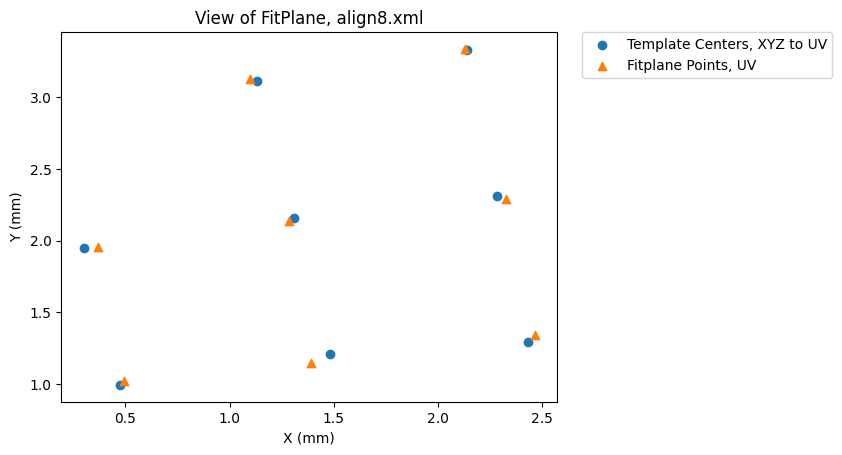

In [33]:
# Plot, in um
a = np.array([fp.get_uv_from_xyz(t) for t in template_centers_xyz])
plt.scatter(a[:,0] * fp.u_norm_mm(), a[:,1] * fp.v_norm_mm(), label="Template Centers, XYZ to UV")
plt.scatter(template_centers_uv[:, 0] * fp.u_norm_mm(), template_centers_uv[:, 1] * fp.v_norm_mm(), label="Fitplane Points, UV",marker='^')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.title("View of FitPlane, "+ str(alignment_xml_path.split("/")[-1]))
plt.show()